In [1]:
import os

QM9_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/filtered_QM9_charges_radicals_stereo.smi"
ChEMBL_CNOF_path = os.environ["DATA"] + "/00_datasets/ChEMBL25/filtered_ChEMBL_charges_radicals_stereo_CNOF.smi"


output_data_path = os.environ["DATA"] + "/07_BBO/02_models/these/01.04_QED_prediction_no_shuffle/"
output_fig_path = os.environ["FIGURES"] + "/07_BBO/04_BBO_chem/01_QED/"

os.makedirs(output_fig_path, exist_ok=True)
os.makedirs(output_data_path, exist_ok=True)

N_JOBS = 10
CV = 100

In [2]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct

kernels = [
    ("RBF", 1.0*RBF(1.0) + WhiteKernel(1.0)),
    ("DotProduct", 1.0*DotProduct(1.0) + WhiteKernel(1.0))
]

In [3]:
import csv
from evomol.evaluation import QEDEvaluationStrategy
import numpy as np

def load_smiles_dataset(path):
    
    all_smiles = []
    
    with open(path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            all_smiles.append(row[0])
            
#     np.random.shuffle(all_smiles)
    return all_smiles
        

def compute_QED(dataset_smiles):
    
    s = QEDEvaluationStrategy()
    return [s.eval_smi(smi) for smi in dataset_smiles]

In [4]:
QM9_smiles = load_smiles_dataset(QM9_path)
ChEMBL_smiles = load_smiles_dataset(ChEMBL_CNOF_path)

print(len(QM9_smiles))
print(len(ChEMBL_smiles))

132040
867606


In [5]:
import numpy as np

def gen_splits(size, n_splits):
    
    for i in range(n_splits):
        
        train_idx = np.arange(i*size, i*size + size)
        test_idx = np.array(np.setdiff1d(np.arange(n_splits*size), train_idx))
        yield train_idx, test_idx
        

In [6]:
gen_splits(1000, 100)

<generator object gen_splits at 0x7f90bb394360>

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from chemdesc.descriptors import ShinglesVectDesc
from tqdm import tqdm
import time
from sklearn.model_selection import cross_validate

def procedure(complete_smiles_list, kernels, test_on=None):
    
    desc_builer = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    qed_eval = QEDEvaluationStrategy()
    
    output_dict = {}
    
    smiles_list = complete_smiles_list[:100000]
    
#     smiles_list = complete_smiles_list[:1000]
   


    X = desc_builer.fit_transform(smiles_list)[0]
    y = []
    for smi in tqdm(smiles_list):
        y.append(qed_eval.eval_smi(smi))
    
    for kernel_tuple in kernels:
        
        generator = gen_splits(1000, 100)
        
#         generator = gen_splits(100, 10)
        
        
        output_dict[kernel_tuple[0]] = {}
        
        kernel = kernel_tuple[1]
        model = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
        
        results = cross_validate(model, X, y, scoring="neg_mean_absolute_error", cv=generator, n_jobs=N_JOBS)
        
        output_dict[kernel_tuple[0]]["scores"] = list(results["test_score"])
        output_dict[kernel_tuple[0]]["fit_times"] = list(results["fit_time"])
        output_dict[kernel_tuple[0]]["score_times"] = list(results["score_time"])
        
    
            
    return output_dict

In [8]:
# train_QM9_test_QM9 = procedure(QM9_smiles, kernels)

In [9]:
# train_QM9_test_QM9

In [10]:
# train_ChEMBL_test_ChEMBL = procedure(ChEMBL_smiles, kernels)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
    
    

In [12]:
# import json
# from os.path import join

# with open(join(output_data_path, "QM9_results_no_shuffle.json"), "w") as f:
#     json.dump(train_QM9_test_QM9, f)

# with open(join(output_data_path, "ChEMBL_results_no_shuffle.json"), "w") as f:
#     json.dump(train_ChEMBL_test_ChEMBL, f)

In [13]:
import json
from os.path import join

with open(join(output_data_path, "QM9_results_no_shuffle.json"), "r") as f:
    QM9_results = json.load(f)
    
with open(join(output_data_path, "ChEMBL_results_no_shuffle.json"), "r") as f:
    ChEMBL_results = json.load(f)

In [14]:

def plot_results(results_dict, dataset_name):
    
    print(dataset_name)
    for kernel in ["RBF", "DotProduct"]:
        print(kernel)
        data = -np.array(results_dict[kernel]["scores"])
        print("Moyenne : " + str(np.mean(data)))
        print("Médiane : " + str(np.median(data)))
        print("Stddev : " + str(np.std(data)))
        print()


In [15]:
plot_results(QM9_results, "QM9")

QM9
RBF
Moyenne : 0.05935738073406394
Médiane : 0.05301027712774446
Stddev : 0.021013057150027

DotProduct
Moyenne : 0.0617636117795949
Médiane : 0.05379453680626828
Stddev : 0.022322166263769625



In [16]:
plot_results(ChEMBL_results, "ChEMBL")

ChEMBL
RBF
Moyenne : 0.08060073313371033
Médiane : 0.08024897431318809
Stddev : 0.002225980079593175

DotProduct
Moyenne : 0.10740029802917644
Médiane : 0.10695931914360253
Stddev : 0.0033620727671276503



In [17]:
QM9_results

{'RBF': {'scores': [-0.043762949286291146,
   -0.04614818905422323,
   -0.05254323366308738,
   -0.051267555187008804,
   -0.09102151320864221,
   -0.05315957783844939,
   -0.05610642639189106,
   -0.047371349611407355,
   -0.05098167981612672,
   -0.07755576424864392,
   -0.049579956190036446,
   -0.04685832516056267,
   -0.04580273610445275,
   -0.04836597738707726,
   -0.054267871591870014,
   -0.04407396651301821,
   -0.053257925666379886,
   -0.04817670643935726,
   -0.04674475499722648,
   -0.051041222101002925,
   -0.0670848307506306,
   -0.08897460264680564,
   -0.14345005810610975,
   -0.04773666247756955,
   -0.07058005261662792,
   -0.10703156904963738,
   -0.14839486403745142,
   -0.10103040738459416,
   -0.10510943315908905,
   -0.12609132898200004,
   -0.104705379336982,
   -0.11629810105141944,
   -0.05503496774843441,
   -0.06324725605415965,
   -0.06051120280666909,
   -0.053362849879768,
   -0.054778458945499965,
   -0.053680783146138236,
   -0.052930634796518994,
   

In [19]:
np.mean(np.absolute(train_QM9_test_QM9["RBF"]['errors_list']))

NameError: name 'train_QM9_test_QM9' is not defined

In [12]:
np.mean(np.absolute(train_ChEMBL_test_ChEMBL["RBF"]['errors_list']))

0.07843659225959264

In [501]:
np.median(np.absolute(train_QM9_test_QM9["RBF"]['errors_list']))

0.023978624753653588

In [502]:
np.median(np.absolute(train_ChEMBL_test_ChEMBL["RBF"]['errors_list']))

0.0641813018658085

In [503]:
np.max(np.absolute(train_QM9_test_QM9["RBF"]['errors_list']))

0.24954813829131967

In [504]:
np.max(np.absolute(train_ChEMBL_test_ChEMBL["RBF"]['errors_list']))

0.5472305500532756

In [13]:
np.mean(np.absolute(train_ChEMBL_test_QM9["RBF"]['errors_list']))

0.18703280712065914

In [14]:
np.mean(np.absolute(train_QM9_test_ChEMBL["RBF"]['errors_list']))

0.17622959201770846

In [15]:
np.mean(np.absolute(train_QM9_test_QM9["DotProduct"]['errors_list']))

0.036984218938800474

In [16]:
np.mean(np.absolute(train_ChEMBL_test_ChEMBL["DotProduct"]['errors_list']))

0.10287471609278162

In [505]:
np.median(np.absolute(train_QM9_test_QM9["DotProduct"]['errors_list']))

0.030220122124364396

In [506]:
np.median(np.absolute(train_ChEMBL_test_ChEMBL["DotProduct"]['errors_list']))

0.08812931606036184

In [507]:
np.max(np.absolute(train_QM9_test_QM9["DotProduct"]['errors_list']))

0.27922613346311853

In [508]:
np.max(np.absolute(train_ChEMBL_test_ChEMBL["DotProduct"]['errors_list']))

0.8317500859792358

In [17]:
np.mean(np.absolute(train_ChEMBL_test_QM9["DotProduct"]['errors_list']))

0.4482743468952801

In [363]:
np.mean(np.absolute(train_QM9_test_ChEMBL["DotProduct"]['errors_list']))

0.27281157994760796

In [20]:
def plot_distrib_errors(train_QM9_test_QM9, train_ChEMBL_test_ChEMBL, train_QM9_test_ChEMBL, train_ChEMBL_test_QM9):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
    
    for t in [(ax1, "RBF"), (ax2, "DotProduct")]:
        
#         for exp in [(train_QM9_test_QM9, "QM9 - QM9"), (train_ChEMBL_test_ChEMBL, "ChEMBL - ChEMBL"),
#                     (train_QM9_test_ChEMBL, "QM9 - ChEMBL"), (train_ChEMBL_test_QM9, "ChEMBL - QM9")]:
            
        for exp in [(train_QM9_test_QM9, "QM9"), (train_ChEMBL_test_ChEMBL, "ChEMBL")]:
            
            print(np.max(np.absolute(np.array(exp[0][t[1]]["errors_list"]).flatten())))
    
            sns.distplot(np.absolute(np.array(exp[0][t[1]]["errors_list"]).flatten()), ax=t[0], label=exp[1],
                         kde=False, bins=np.linspace(0, 0.85, 35))
            t[0].set_title("Fonction noyau : " + t[1])
            t[0].set_xlabel("Erreur moyenne absolue (MAE)")
#             plt.yscale("log")
            plt.xlim(0, 0.85)
            plt.legend()
    
    plt.savefig(join(output_fig_path, "QED_pred_dist_mae.png"), dpi=250)
        
            

In [21]:
plot_distrib_errors(train_QM9_test_QM9, train_ChEMBL_test_ChEMBL, 
                    train_QM9_test_ChEMBL, train_ChEMBL_test_QM9)

NameError: name 'train_QM9_test_QM9' is not defined

In [530]:
def errors_vs_target(data, key):
    plt.figure(figsize=(5, 7))
    plt.scatter(np.array(data[key]["targets_list"]).flatten(), 
                np.array(data[key]["errors_list"]).flatten() + np.array(data[key]["targets_list"]).flatten(),
                alpha=0.2, marker=',',lw=0,s=1)
    plt.plot([0, 1], [0, 1], color='g')
    plt.xlim((0, 1))

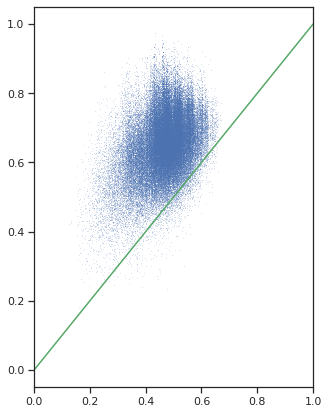

In [485]:
errors_vs_target(train_ChEMBL_test_QM9, "RBF")

In [25]:
def eval_model(model, X_train, y_train, X_test, y_test, size):
    
    tstart = time.time()
    model.fit(X_train[:size], y_train[:size])
    fit_time = time.time() - tstart
    
    tstart = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - tstart
    
    MAE = np.mean(np.absolute(y_pred - y_test))
    
    return MAE, fit_time, predict_time
    

def data_efficiency_experiments(kernels, QM9_smiles, ChEMBL_smiles):
    
    output_dict = {kernel[0]: {
        "size": [],
        "QM9_fit_time": [],
        "QM9_predict_time": [],
        "QM9_MAE": [],
        "ChEMBL_fit_time": [],
        "ChEMBL_predict_time": [],
        "ChEMBL_MAE": []
    } for kernel in kernels}
    
    dataset_sizes = [10, 30, 100, 300, 1000, 3000, 10000]
    
    desc_builer = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    qed_eval = QEDEvaluationStrategy()
    
    QM9_train_smiles, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
    ChEMBL_train_smiles, ChEMBL_test_smiles = train_test_split(ChEMBL_smiles, test_size=50000)
    
    QM9_train_smiles = QM9_train_smiles[:10000]
    ChEMBL_train_smiles = ChEMBL_train_smiles[:10000]
    
    QM9_train_X = desc_builer.fit_transform(QM9_train_smiles)[0]
    QM9_test_X = desc_builer.fit_transform(QM9_test_smiles)[0]
    ChEMBL_train_X = desc_builer.fit_transform(ChEMBL_train_smiles)[0]
    ChEMBL_test_X = desc_builer.fit_transform(ChEMBL_test_smiles)[0]
    
    QM9_train_y = [qed_eval.eval_smi(smi) for smi in tqdm(QM9_train_smiles)]
    QM9_test_y = [qed_eval.eval_smi(smi) for smi in tqdm(QM9_test_smiles)]
    ChEMBL_train_y = [qed_eval.eval_smi(smi) for smi in tqdm(ChEMBL_train_smiles)]
    ChEMBL_test_y = [qed_eval.eval_smi(smi) for smi in tqdm(ChEMBL_test_smiles)]
    
    for kernel in kernels:
        print(kernel[0])
        model = GaussianProcessRegressor(kernel=kernel[1], normalize_y=True)
        
        for dataset_size in dataset_sizes:
            print(dataset_size)
            
            MAE_QM9, time_fit_QM9, time_predict_QM9 = eval_model(model, QM9_train_X, QM9_train_y, 
                                                                 QM9_test_X, QM9_test_y, 
                                                                 dataset_size)
            
            MAE_ChEMBL, time_fit_ChEMBL, time_predict_ChEMBL = eval_model(model, ChEMBL_train_X, ChEMBL_train_y, 
                                                                          ChEMBL_test_X, ChEMBL_test_y, 
                                                                          dataset_size)
            print(time_fit_ChEMBL)
            output_dict[kernel[0]]["size"].append(dataset_size)
            output_dict[kernel[0]]["QM9_fit_time"].append(time_fit_QM9)
            output_dict[kernel[0]]["QM9_predict_time"].append(time_predict_QM9)
            output_dict[kernel[0]]["QM9_MAE"].append(MAE_QM9)
            output_dict[kernel[0]]["ChEMBL_fit_time"].append(time_fit_ChEMBL)
            output_dict[kernel[0]]["ChEMBL_predict_time"].append(time_predict_ChEMBL)
            output_dict[kernel[0]]["ChEMBL_MAE"].append(MAE_ChEMBL)
            
    return output_dict
            

In [26]:
output_data_efficiency = data_efficiency_experiments(kernels, QM9_smiles, ChEMBL_smiles)

MM program : obabel_mmff94
None


100%|██████████| 50000/50000 [01:53<00:00, 439.03it/s]


RBF
10
0.0834650993347168
30
0.03742694854736328
100
0.25016283988952637
300
1.6282985210418701
1000
17.97664475440979
3000
136.24309635162354
10000
1718.6880798339844
DotProduct
10
0.05096292495727539
30
0.0597994327545166
100
0.04253125190734863
300
0.17673730850219727
1000
2.124826431274414
3000
18.412991523742676
10000
389.22599267959595


In [288]:
def time_desc(QM9_smiles, ChEMBL_smiles):
        
    desc_builer = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    
    _, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
    _, ChEMBL_test_smiles = train_test_split(ChEMBL_smiles, test_size=50000)
    
    tstart = time.time()
    desc_builer.fit_transform(QM9_test_smiles)
    time_QM9_desc = time.time() - tstart
    
    tstart = time.time()
    desc_builer.fit_transform(ChEMBL_test_smiles)
    time_ChEMBL_desc = time.time() - tstart
    
    return time_QM9_desc, time_ChEMBL_desc

In [289]:
time_QM9_desc, time_ChEMBL_desc = time_desc(QM9_smiles, ChEMBL_smiles)

MM program : obabel_mmff94
None


100%|██████████| 50000/50000 [07:35<00:00, 109.70it/s]


In [301]:
time_QM9_desc/50

2.6651350975036623

In [302]:
time_ChEMBL_desc/50

9.116340651512147

In [22]:
import numpy as np
import pandas as pd
from os.path import join



def plot_data_efficiency(output_data_efficiency, time_QM9_desc, time_ChEMBL_desc):
    
    d = {"size": [], "Données": [], "predict_time": [], "desc_predict_time": [], "fit_time": [], "MAE": [], 
         "Noyau": []} 
    
    k = "RBF"
    
    predict_time_denominateur = 50
    
    for k in ["RBF", "DotProduct"]:
        d["size"].extend(output_data_efficiency[k]["size"])
        d["Données"].extend(np.full(len(output_data_efficiency[k]["size"],), "QM9"))
        d["Noyau"].extend(np.full(len(output_data_efficiency[k]["size"],), k))
        d["fit_time"].extend(output_data_efficiency[k]["QM9_fit_time"])
        d["predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur)
        d["desc_predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur + time_QM9_desc/predict_time_denominateur)
        d["MAE"].extend(output_data_efficiency[k]["QM9_MAE"])

        d["size"].extend(output_data_efficiency[k]["size"])
        d["Données"].extend(np.full(len(output_data_efficiency[k]["size"],), "ChEMBL"))
        d["Noyau"].extend(np.full(len(output_data_efficiency[k]["size"],), k))
        d["fit_time"].extend(output_data_efficiency[k]["ChEMBL_fit_time"])
        d["predict_time"].extend(np.array(output_data_efficiency[k]["ChEMBL_predict_time"])/predict_time_denominateur)
        d["desc_predict_time"].extend(np.array(output_data_efficiency[k]["ChEMBL_predict_time"])/predict_time_denominateur + time_ChEMBL_desc/predict_time_denominateur)
        d["MAE"].extend(output_data_efficiency[k]["ChEMBL_MAE"])

        
    df = pd.DataFrame.from_dict(d)

   
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=df, x="size", y="MAE", hue="Données", style="Noyau", legend="brief")
    plt.xscale("log")
    plt.ylabel("Erreur moyenne absolue (MAE)")
    plt.xlabel("Taille des données d'entraînement")
    plt.ylim(0, 0.2)
    
    plt.savefig(join(output_fig_path, "MAE.png"), dpi=250)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), sharex=True) #sharey=True)

    
#     handles, labels = ax1.get_legend_handles_labels()
#     ax1.legend(handles=handles[:2], labels=labels, title="Whatever else")
#     ax1.legend(handles=handles[2:4], labels=labels, title="Whatever else")
    

    sns.lineplot(x="size", y="fit_time", hue="Données", style="Noyau", data=df[df["Données"] == "QM9"], ax=ax1, legend=False)
    sns.lineplot(x="size", y="predict_time", hue="Données", style="Noyau", data=df[df["Données"] == "QM9"], ax=ax2, legend=False)
    sns.lineplot(x="size", y="desc_predict_time", hue="Données", style="Noyau", data=df, ax=ax3)
    
    ax1.set_xlabel("Taille des données d'entraînement")
    ax1.set_ylabel("Temps (s)")
    ax1.set_yscale("log")
    ax1.set_ylim(1e-3, 1e4)
    ax1.set_title("Entraînement")
    
    ax2.set_xlabel("Taille des données d'entraînement")
    ax2.set_ylabel("")
    ax2.set_yscale("log")
    ax2.set_ylim(1e-3, 1e4)
    ax2.set_title("Prédiction (1000 mol.)")
    
    ax3.set_xlabel("Taille des données d'entraînement")
    ax3.set_ylabel("")
    ax3.set_yscale("log")
    ax3.set_ylim(1e-3, 1e4)
    ax3.set_title("Descripteurs + prédiction (1000 mol.)")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(join(output_fig_path, "times.png"), dpi=250)
    
    return df

In [23]:
plot_data_efficiency(output_data_efficiency, time_QM9_desc, time_ChEMBL_desc)

NameError: name 'output_data_efficiency' is not defined

In [358]:
output_data_efficiency

{'RBF': {'size': [10, 30, 100, 300, 1000, 3000, 10000],
  'QM9_fit_time': [0.019952058792114258,
   0.07251143455505371,
   0.20428752899169922,
   1.34132981300354,
   22.652343034744263,
   201.54881191253662,
   2082.1174850463867],
  'QM9_predict_time': [0.7057797908782959,
   1.7295444011688232,
   5.229296922683716,
   17.88055109977722,
   65.02685379981995,
   190.96866369247437,
   609.3931572437286],
  'QM9_MAE': [0.057175352674810026,
   0.05151739784580509,
   0.046040555434511216,
   0.03840978952212264,
   0.030783076285534925,
   0.02665319671586204,
   0.022739860646973517],
  'ChEMBL_fit_time': [0.0362241268157959,
   0.1288614273071289,
   0.24900341033935547,
   1.6635127067565918,
   18.384639739990234,
   119.24578499794006,
   1736.3754134178162],
  'ChEMBL_predict_time': [0.735382080078125,
   1.7080714702606201,
   5.174376487731934,
   16.335249423980713,
   66.14246678352356,
   189.44593334197998,
   639.6433796882629],
  'ChEMBL_MAE': [0.18792859552362626,
 